# Classification par régression logistique (INF8225)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Objectif

L’objectif est de mettre résoudre un problème de classification d'images en utilisant l’approche de descente du gradient (gradient descent) pour optimiser la log-vraisemblance négative (negative log-likelihood) comme fonction de perte.

Ici on implémentera l’algorithme de descente de gradient stochastique par mini-ensemble (mini-batch stochastic gradient descent).  On cherchera également à optimiser les paramètres d’un modèle étant donné un ensemble de données d’apprentissage, en utilisant un ensemble de validation pour déterminer quand arrêter l'optimisation, et finalement de montrer la performance sur l’ensemble du test.

## Théorie: la régression logistique et le calcul du gradient
Il est possible d’encoder l’information concernant l’étiquetage avec des vecteurs multinomiaux (one-hot vectors), c.-à-d. un vecteur de zéros avec un seul 1 pour indiquer quand la classe $C=k$ dans la dimension $k$. Par exemple, le vecteur $\mathbf{y}=[0, 1, 0, \cdots, 0]^T$ représente la deuxième classe. Les caractéristiques (features) sont données par des vecteurs $\mathbf{x}_i \in \mathbb{R}^{D}$. En définissant les paramètres de notre modèle comme : $\mathbf{W}=[\mathbf{w}_1, \cdots, \mathbf{w}_K]^T$ et $\mathbf{b}=[b_1, b_2, \cdots  b_K]^T$ et la fonction softmax comme fonction de sortie, on peut exprimer notre modèle sous la forme :
\begin{eqnarray}
    p(\mathbf{y}|\mathbf{x}) 
    &=& \frac{\exp(\mathbf{y}^T \mathbf{W} \mathbf{x} + \mathbf{y}^T \mathbf{b})}{\sum_{\mathbf{y}_k \in \mathcal{Y}} \exp(\mathbf{y}_k^T \mathbf{W} \mathbf{x} + \mathbf{y}_k^T \mathbf{b})} 
\end{eqnarray}
L'ensemble de données consiste de $n$ paires (label, input) de la forme $\mathcal{D}:=(\mathbf{\tilde{y}}_i, \mathbf{\tilde{x}}_i)_{i=1}^n$, où nous utilisons l'astuce de redéfinir $\mathbf{\tilde{x}}_i = [\mathbf{\tilde{x}}_i^T 1]^T$ et nous redéfinissions la matrice de paramètres $\boldsymbol{\theta} \in \mathbb{R}^{K\times(D+1)}$ (voir des notes de cours pour la relation entre $\boldsymbol{\theta}$ et $\mathbf{W}$). Notre fonction de perte, la log-vraisemblance négative des données selon notre modèle est définie comme:
\begin{equation}
    \mathcal{L}\big( \boldsymbol{\theta}, \mathcal{D} \big) := -\log \prod_{i=1}^N P(\mathbf{\tilde{y}}_i|\mathbf{\tilde{x}}_i; \boldsymbol{\theta})
\end{equation}
Le gradient de la fonction de perte par rapport aux paramètres du modèle est:
\begin{eqnarray}
    \frac{\partial}{\partial \boldsymbol{\theta}} \mathcal{L}\big( \boldsymbol{\theta}, \mathcal{D} \big) 
    &=& -\sum_{i=1}^N \frac{\partial}{\partial \boldsymbol{\theta}} \Bigg\{\log \Bigg(\frac{\exp(\mathbf{\tilde{y}}_i^T \boldsymbol{\theta} \mathbf{\tilde{x}}_i)}{\sum_{\mathbf{y}_k \in \mathcal{Y}} \exp(\mathbf{y}_k^T \boldsymbol{\theta} \mathbf{\tilde{x}}_i)} \Bigg) \Bigg\} \\
    &=& -\sum_{i=1}^N \left(\mathbf{\tilde{y}}_i \mathbf{\tilde{x}}^T_i- \sum_{\mathbf{y}_k \in \mathcal{Y}} P(\mathbf{y}_k|\mathbf{\tilde{x}}_i,\boldsymbol{\theta}) \mathbf{y}_k \mathbf{\tilde{x}}^T_i \right) \\
    &=& \sum_{i=1}^N \mathbf{\hat{p}}_i \mathbf{\tilde{x}}^T_i - \sum_{i=1}^N \mathbf{\tilde{y}}_i \mathbf{\tilde{x}}^T_i
\end{eqnarray}
où $\mathbf{\hat{p}}_i$ est un vecteur de probabilités produit par le modèle pour l'exemple $\mathbf{\tilde{x}}_i$ et $\mathbf{\tilde{y}}_i$ est le vrai *label* pour ce même exemple.

Finalement, il reste à discuter de l'évaluation du modèle. Habituellement dans le contexte de l'apprentissage automatique, on utilise la précision comme métrique d'évaluation.

La précision est définie comme le rapport du nombre d'échantillons bien classés sur le nombre total d'échantillons à classer:
$$
\tau_{acc} := \frac{|\mathcal{C}|}{|\mathcal{D}|} 
$$
où l'ensemble des échantillons bien classés $\mathcal{C}$ est:
$$
\mathcal{C} := \lbrace (\mathbf{x}, \mathbf{y}) \in \mathcal{D} \, | \, \underset{k}{\arg\max} \, \, P(\cdot|\mathbf{\tilde{x}}_i; \boldsymbol{\theta})_k = \underset{k}{\arg\max} \, \, \tilde{y}_{i,k} \rbrace
$$ 
En mots, il s'agit du sous-ensemble d'échantillons pour lesquels la classe la plus probable selon notre modèle correspond à la vraie classe.

##  Chargement des données

In [ ]:
# fonctions pour charger les ensembles de donnees
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt



def get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=1):
  torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats seed(matricule étudiant)
  dataset = FashionMNIST("./dataset", train=True,  download=True, transform=transforms.Compose([transforms.ToTensor()]))
  torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats seed(matricule étudiant)
  dataset_test = FashionMNIST("./dataset", train=False,  download=True, transform=transforms.Compose([transforms.ToTensor()]))
  len_train = int(len(dataset) * (1.-val_percentage))
  len_val = len(dataset) - len_train
  torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats seed(matricule étudiant)
  dataset_train, dataset_val = random_split(dataset, [len_train, len_val])
  torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats seed(matricule étudiant)
  data_loader_train = DataLoader(dataset_train, batch_size=batch_size,shuffle=True,num_workers=4)
  torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats seed(matricule étudiant)
  data_loader_val   = DataLoader(dataset_val, batch_size=batch_size,shuffle=True,num_workers=4)
  torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats seed(matricule étudiant)
  data_loader_test  = DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=4)
  return data_loader_train, data_loader_val, data_loader_test

def reshape_input(x, y):
    x = x.view(-1, 784)
    y = torch.FloatTensor(len(y), 10).zero_().scatter_(1,y.view(-1,1),1)
    return x, y
    

# call this once first to download the datasets
_ = get_fashion_mnist_dataloaders()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# simple logger to track progress during training
class Logger:
    def __init__(self):
        self.losses_train = []
        self.losses_valid = []
        self.accuracies_train = []
        self.accuracies_valid = []

    def log(self, accuracy_train=0, loss_train=0, accuracy_valid=0, loss_valid=0):
        self.losses_train.append(loss_train)
        self.accuracies_train.append(accuracy_train)
        self.losses_valid.append(loss_valid)
        self.accuracies_valid.append(accuracy_valid)

    def plot_loss_and_accuracy(self, train=True, valid=True):

        assert train and valid, "Cannot plot accuracy because neither train nor valid."

        figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                            figsize=(12, 6))
        
        if train:
            ax1.plot(self.losses_train, label="Training")
            ax2.plot(self.accuracies_train, label="Training")
        if valid:
            ax1.plot(self.losses_valid, label="Validation")
            ax1.set_title("CrossEntropy Loss")
            ax2.plot(self.accuracies_valid, label="Validation")
            ax2.set_title("Accuracy")
        
        for ax in figure.axes:
            ax.set_xlabel("Epoch")
            ax.legend(loc='best')
            ax.set_axisbelow(True)
            ax.minorticks_on()
            ax.grid(True, which="major", linestyle='-')
            ax.grid(True, which="minor", linestyle='--', color='lightgrey', alpha=.4)            
  
    def print_last(self):
        print(f"Epoch {len(self.losses_train):2d}, \
                Train:loss={self.losses_train[-1]:.3f}, accuracy={self.accuracies_train[-1]*100:.1f}%, \
                Valid: loss={self.losses_valid[-1]:.3f}, accuracy={self.losses_valid[-1]*100:.1f}%", flush=True)

## Aperçu de l'ensemble de données FashionMnist

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


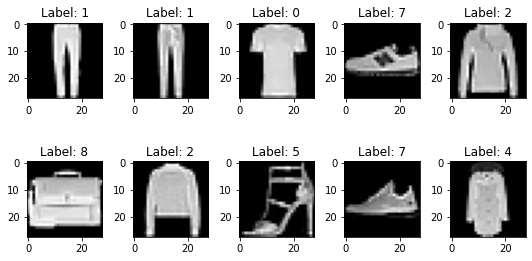

In [ ]:
def plot_samples():
  a, _, _ = get_fashion_mnist_dataloaders()
  num_row = 2
  num_col = 5# plot images
  num_images = num_row * num_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i, (x,y) in enumerate(a):
      if i >= num_images:
        break
      ax = axes[i//num_col, i%num_col]
      x = (x.numpy().squeeze() * 255).astype(int)
      y = y.numpy()[0]
      ax.imshow(x, cmap='gray')
      ax.set_title(f"Label: {y}")
      
  plt.tight_layout()
  plt.show()
plot_samples()

## Code

In [ ]:
from gc import DEBUG_UNCOLLECTABLE
from logging import logProcesses

def accuracy(y, y_pred) :
    # nombre d'éléments à classifier.
    card_D = y.shape[0]
    # calcul du nombre d'éléments bien classifiés.
    ind_pred = torch.argmax(y_pred, dim=1)
    ind_target = torch.argmax(y, dim=1)
    card_C = (ind_pred == ind_target).sum()
    # calcul de la précision de classification.
    acc = np.abs(card_C)/np.abs(card_D)
    return acc, (card_C, card_D)

def accuracy_and_loss_whole_dataset(data_loader, model):
    cardinal = 0
    loss     = 0.
    n_accurate_preds  = 0.

    for x, y in data_loader:
        x, y = reshape_input(x, y)
        y_pred                = model.forward(x)
        xentrp                = cross_entropy(y, y_pred)
        _, (n_acc, n_samples) = accuracy(y, y_pred)

        cardinal = cardinal + n_samples
        loss     = loss + xentrp
        n_accurate_preds  = n_accurate_preds + n_acc

    loss = loss / float(cardinal)
    acc  = n_accurate_preds / float(cardinal)

    return acc, loss

def cross_entropy(y, y_pred): 
    #  calcul de la valeur d'entropie croisée.
    epsilon = 1e-8  # Pour éviter le cas log(0)
    loss = -(y*torch.log(y_pred + epsilon)).sum()
    return loss

def softmax(x, axis=-1):
    #  calcul des valeurs de softmax(x)
    x = x - torch.max(x, axis=1, keepdims=True)[0]   # Pour que softmax soit numériquement stable et sans modifier le résultat
    values = torch.exp(x)/torch.exp(x).sum(axis=1, keepdims=True)
    
    return  values
  
def inputs_tilde(x, axis=-1):
    # augments the inputs `x` with ones along `axis` 
    X1 = torch.ones([len(x),1])
    x_tilde = torch.cat([x,X1], axis=axis)
    return x_tilde

In [ ]:
class LinearModel:
    def __init__(self, num_features, num_classes):
      torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats 
      self.params = torch.normal(0, 0.01, (num_features + 1, num_classes))
      
      self.t = 0 
      self.m_t = 0 # pour Adam: moyennes mobiles du gradient
      self.v_t = 0 # pour Adam: moyennes mobiles du carré du gradient
        
    def forward(self, x):
      # calcul des outputs en fonction des inputs `x`.
      inputs = inputs_tilde(x)
      outputs = softmax(torch.matmul(inputs,self.params))
      return outputs

    def get_grads(self, y, y_pred, X): 
      # calcul des gradients.
      x_tilde = inputs_tilde(X)
      grads = torch.matmul(x_tilde.T, y_pred) - torch.matmul(x_tilde.T, y)
      return grads

    def sgd_update(self, lr, grads):
      # mise à jour des paramètres ici.
      self.params = self.params - lr * grads

      pass
    
    def adam_update(self, lr, grads):
      # mise à jour des paramètres
      epsilon = 1e-8
      beta_1 = 0.9
      beta_2 = 0.999

      self.t += 1

      self.m_t = beta_1*self.m_t + (1 - beta_1)*grads
      m_t_corrected = self.m_t/(1 - beta_1**self.t)

      self.v_t = beta_2*self.v_t + (1 - beta_2)*(grads**2)
      v_t_corrected = self.v_t/(1 - beta_2**self.t)

      self.params = self.params - lr*(m_t_corrected/(torch.sqrt(v_t_corrected)+epsilon))
      pass

def train(model, lr=0.1, nb_epochs=10, sgd=True, data_loader_train=None, data_loader_val=None):
    best_model = None
    best_val_accuracy = 0
    
    best_accuracy = 0
    logger = Logger()

    for epoch in range(nb_epochs+1):
        # at epoch 0 evaluate random initial model
        #   then for subsequent epochs, do optimize before evaluation.
        
        if epoch > 0:
          for x, y in data_loader_train:
              x, y = reshape_input(x, y)
              y_pred = model.forward(x)
              loss = cross_entropy(y, y_pred)
              grads = model.get_grads(y, y_pred, x)
              if sgd:
                model.sgd_update(lr, grads)
              else:
                model.adam_update(lr, grads)
        
        accuracy_train, loss_train = accuracy_and_loss_whole_dataset(data_loader_train, model)
        accuracy_val, loss_val = accuracy_and_loss_whole_dataset(data_loader_val, model)
        
        if accuracy_val > best_accuracy:
          #
          best_model = model
          best_val_accuracy, best_accuracy = accuracy_val, accuracy_val
          #
          pass   #  record the best model parameters and best validation accuracy

        logger.log(accuracy_train, loss_train, accuracy_val, loss_val)
        
        if epoch >=0: 
          print(f"Epoch {epoch:2d}, \
                  Train: loss={loss_train.item():.3f}, accuracy={accuracy_train.item()*100:.1f}%, \
                  Valid: loss={loss_val.item():.3f}, accuracy={accuracy_val.item()*100:.1f}%", flush=True)

    return best_model, best_val_accuracy, logger


## Évaluation

### SGD: Recherche d'hyperparamètres

In [ ]:
# SGD
# Résultats pour différents taux d'apprentissage, e.g. 0.1, 0.01, 0.001, et différentes tailles de mini-batch, e.g. 1, 20, 200, 1000.
batch_size_list = [5,20,200,1000]   
lr_list = [0.1,0.01,0.001]          

torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats 

with torch.no_grad():
  for lr in lr_list:
    for batch_size in batch_size_list:
      print("------------------------------------------------------------------")
      print("Training model with a learning rate of {0} and a batch size of {1}".format(lr, batch_size))
      data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)
      
      model = LinearModel(num_features=784, num_classes=10)
      _, val_accuracy, _ = train(model,lr=lr, nb_epochs=5, sgd=True, data_loader_train=data_loader_train, data_loader_val=data_loader_val)


      print(f"validation accuracy = {val_accuracy*100:.3f}")

------------------------------------------------------------------
Training model with a learning rate of 0.1 and a batch size of 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  0,                   Train: loss=2.303, accuracy=13.2%,                   Valid: loss=2.305, accuracy=13.2%
Epoch  1,                   Train: loss=1.724, accuracy=83.5%,                   Valid: loss=1.890, accuracy=82.1%
Epoch  2,                   Train: loss=1.602, accuracy=85.0%,                   Valid: loss=1.803, accuracy=83.2%
Epoch  3,                   Train: loss=1.967, accuracy=82.9%,                   Valid: loss=2.150, accuracy=81.4%
Epoch  4,                   Train: loss=2.283, accuracy=79.8%,                   Valid: loss=2.597, accuracy=78.1%
Epoch  5,                   Train: loss=1.688, accuracy=83.8%,                   Valid: loss=1.889, accuracy=82.2%
validation accuracy = 83.217
------------------------------------------------------------------
Training model with a learning rate of 0.1 and a batch size of 20
Epoch  0,                   Train: loss=2.303, accuracy=13.2%,                   Valid: loss=2.305, accuracy=13.2%
Epoch  1,                   Train

#### **Tableau pour la précision sur l'ensemble de validation**
N.B. que les lignes correspondent aux valeurs du taux d'apprentisage et les colonnes correspondent au valeur du batch size. 

learning rate\batch_size  | 5 | 20 | 200 | 1000 
-------------------|------------------|------------------|------------------|------------------|
**0.1**   | 83.217%  | 82.100% | 81.900% | 80.217% | - |
**0.01** | <u>**84.450%**</u>  | 82.950% | 83.250% | 78.333% | - |
**0.001**  | 83.917%  | 83.967% | 82.883% | 77.350% | - |

### SGD: Analyse du meilleur modèle

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  0,                   Train: loss=2.303, accuracy=13.2%,                   Valid: loss=2.305, accuracy=13.2%
Epoch  1,                   Train: loss=0.458, accuracy=84.9%,                   Valid: loss=0.495, accuracy=83.4%
Epoch  2,                   Train: loss=0.457, accuracy=84.9%,                   Valid: loss=0.499, accuracy=83.4%
Epoch  3,                   Train: loss=0.430, accuracy=86.2%,                   Valid: loss=0.473, accuracy=84.5%
Epoch  4,                   Train: loss=0.462, accuracy=84.5%,                   Valid: loss=0.524, accuracy=82.7%
Epoch  5,                   Train: loss=0.433, accuracy=85.5%,                   Valid: loss=0.477, accuracy=84.0%
Epoch  6,                   Train: loss=0.576, accuracy=82.3%,                   Valid: loss=0.643, accuracy=80.5%
Epoch  7,                   Train: loss=0.408, accuracy=86.6%,                   Valid: loss=0.466, accuracy=84.9%
Epoch  8,                   Train: loss=0.454, accuracy=85.0%,                  

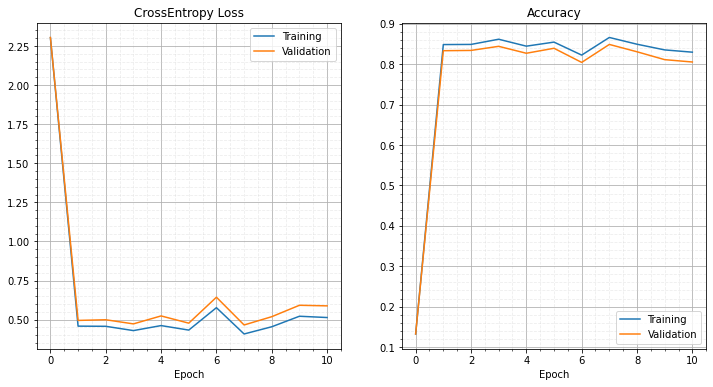

In [ ]:
# SGD
# Résultats pour la meilleure configuration trouvée ci-dessus.
batch_size = 5 
lr = 0.01         

torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats 

with torch.no_grad():
  data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

  model = LinearModel(num_features=784, num_classes=10)
  best_model, best_val_accuracy, logger = train(model,lr=lr, nb_epochs=10, sgd=True, 
                                                data_loader_train=data_loader_train, data_loader_val=data_loader_val)
  logger.plot_loss_and_accuracy()
  print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

  accuracy_test, loss_test = accuracy_and_loss_whole_dataset(data_loader_test, best_model)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

### Adam: Recherche d'hyperparamètres

Implémenter Adam (recherche d'hyperparamètres et analyse du meilleur modèle) cette fois en utilisat Adam, et comparer les performances finales avec le meilleur modèle SGD.

In [ ]:
# ADAM
# Résultats pour différents taux d'apprentissage, e.g. 0.1, 0.01, 0.001, et différentes tailles de mini-batch, e.g. 1, 20, 200, 1000.
batch_size_list = [5,20,200,1000]   # Define ranges in a list
lr_list = [0.1,0.01,0.001]           # Define ranges in a list

torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats

with torch.no_grad():
  for lr in lr_list:
    for batch_size in batch_size_list:
      print("------------------------------------------------------------------")
      print("Training model with a learning rate of {0} and a batch size of {1}".format(lr, batch_size))
      data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)
      
      model = LinearModel(num_features=784, num_classes=10)
      _, val_accuracy, _ = train(model,lr=lr, nb_epochs=5, sgd=False, data_loader_train=data_loader_train, data_loader_val=data_loader_val)
      print(f"validation accuracy = {val_accuracy*100:.3f}")

------------------------------------------------------------------
Training model with a learning rate of 0.1 and a batch size of 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  0,                   Train: loss=2.303, accuracy=13.2%,                   Valid: loss=2.305, accuracy=13.2%
Epoch  1,                   Train: loss=2.901, accuracy=81.2%,                   Valid: loss=3.236, accuracy=79.0%
Epoch  2,                   Train: loss=2.956, accuracy=81.2%,                   Valid: loss=3.311, accuracy=79.1%
Epoch  3,                   Train: loss=2.582, accuracy=83.7%,                   Valid: loss=2.887, accuracy=82.1%
Epoch  4,                   Train: loss=2.809, accuracy=82.0%,                   Valid: loss=3.064, accuracy=80.4%
Epoch  5,                   Train: loss=3.232, accuracy=80.1%,                   Valid: loss=3.501, accuracy=78.6%
validation accuracy = 82.050
------------------------------------------------------------------
Training model with a learning rate of 0.1 and a batch size of 20
Epoch  0,                   Train: loss=2.303, accuracy=13.2%,                   Valid: loss=2.305, accuracy=13.2%
Epoch  1,                   Train

#### **Tableau pour la précision sur l'ensemble de validation**
N.B. que les lignes correspondent aux valeurs du taux d'apprentisage et les colonnes correspondent au valeur du batch size. 

learning rate\batch_size  | 5 | 20 | 200 | 1000 
-------------------|------------------|------------------|------------------|------------------|
**0.1**   | 82.050%  | 82.117% | 82.783% | 82.067% | - |
**0.01** | 82.283%  | 83.083% | 84.350% | 84.183% | - |
**0.001**  | <u>**85.183%**</u>  | 84.933% | 83.850% | 81.283% | - |

### Adam: Analyse du meilleur modèle

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  0,                   Train: loss=2.303, accuracy=13.2%,                   Valid: loss=2.305, accuracy=13.2%
Epoch  1,                   Train: loss=0.430, accuracy=85.3%,                   Valid: loss=0.457, accuracy=84.0%
Epoch  2,                   Train: loss=0.451, accuracy=84.7%,                   Valid: loss=0.488, accuracy=83.3%
Epoch  3,                   Train: loss=0.397, accuracy=86.3%,                   Valid: loss=0.435, accuracy=85.2%
Epoch  4,                   Train: loss=0.408, accuracy=85.8%,                   Valid: loss=0.452, accuracy=84.5%
Epoch  5,                   Train: loss=0.410, accuracy=85.9%,                   Valid: loss=0.458, accuracy=84.0%
Epoch  6,                   Train: loss=0.394, accuracy=86.2%,                   Valid: loss=0.448, accuracy=84.3%
Epoch  7,                   Train: loss=0.409, accuracy=85.5%,                   Valid: loss=0.472, accuracy=83.2%
Epoch  8,                   Train: loss=0.381, accuracy=86.7%,                  

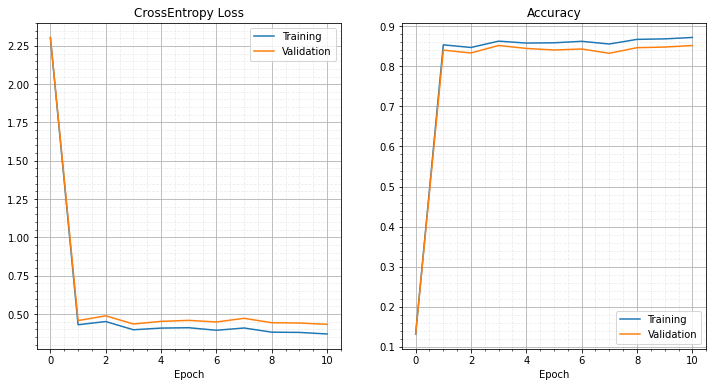

In [ ]:
# ADAM
# Résultats pour la meilleure configuration trouvez ci-dessus.
batch_size = 5 
lr = 0.001         

torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats

with torch.no_grad():
  data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

  model = LinearModel(num_features=784, num_classes=10)
  best_model, best_val_accuracy, logger = train(model,lr=lr, nb_epochs=10, sgd=False, 
                                                data_loader_train=data_loader_train, data_loader_val=data_loader_val)
  logger.plot_loss_and_accuracy()
  print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

  accuracy_test, loss_test = accuracy_and_loss_whole_dataset(data_loader_test, best_model)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

### Analyse des Résultats


Afin de pouvoir reproduire les mêmes résultats à chaque fois, j’ai fixé un seed(2103232).
</br>
## SGD
Après l’implémentation du code, j’ai pu obtenir les résultats de précisions suivants en fonction de la taille du batch et du taux d’apprentissage :
 

learning rate\batch_size  | 5 | 20 | 200 | 1000 
-------------------|------------------|------------------|------------------|------------------|
**0.1**   | 83.217%  | 82.100% | 81.900% | 80.217% | - |
**0.01** | <u>**84.450%**</u>  | 82.950% | 83.250% | 78.333% | - |
**0.001**  | 83.917%  | 83.967% | 82.883% | 77.350% | - |

</br>
On peut voir qu’on obtient une précision autour des 80% dans tous les cas. Seules les paires (batch=1000, lr=0.01) et (batch=1000, lr=0.001) donnent des résultats légèrement inférieurs à 80% (respectivement 78.3% et 77.4%). On notera donc que la taille du batch a également son influence sur la précision. Toutefois, on remarque logiquement que plus le batch est grand, plus la vitesse d’exécution est rapide. C’est pourquoi j’ai écarté le cas « batch-size=1 » pour le remplacer par 5 pour avoir un temps de calcul plus raisonnable. 
On obtient alors le meilleur résultat pour batch-size=5 et taux d’apprentissage égale à 0.01.
En utilisant ce résultat pour tester le meilleur modèle, on obtient les courbes données ci-dessus (partie SGD).

On remarque que notre modèle apprend bien. En effet, à l’epoch 0, le modèle effectue la première propagation avec les paramètres aléatoires initiaux ce qui explique la perte élevée et la précision de 10%. Puis la modèle apprend en actualisant les paramètres par la minimisation de l’entropie croisée. On remarque bien que l’entropie croisée diminue autour de 0.5. La précision est en effet bien meilleure, avec une précision maximale de validation atteinte à l’epoch 7 avec 84.917%.


## ADAM
Cette fois-ci en utilisant ADAM pour l’actualisation, j’ai pu obtenir les résultats de précisions suivants en fonction de la taille du batch et du taux d’apprentissage :

learning rate\batch_size  | 5 | 20 | 200 | 1000 
-------------------|------------------|------------------|------------------|------------------|
**0.1**   | 82.050%  | 82.117% | 82.783% | 82.067% | - |
**0.01** | 82.283%  | 83.083% | 84.350% | 84.183% | - |
**0.001**  | <u>**85.183%**</u>  | 84.933% | 83.850% | 81.283% | - | 

</br>
On peut voir qu’on obtient une précision entre 81 et 85% dans tous les cas. Les résultats sont donc légèrement supérieurs que précédemment. On obtient alors le meilleur résultat pour batch-size=5 et taux d’apprentissage égale à 0.001, avec un taux de précision de 85%. 
En utilisant ce résultat pour tester le meilleur modèle, on obtient les courbes données ci-dessus (partie ADAM).

On remarque que notre modèle apprend bien. En effet, à l’epoch 0, le modèle effectue la première propagation avec les paramètres aléatoires initiaux ce qui explique la perte élevée et la précision de 13%. Puis la modèle apprend en actualisant les paramètres par la méthode ADAM. On remarque bien que l’entropie croisée diminue autour de 0.370. La précision est en effet bien meilleure, avec une précision maximale de validation atteinte à l’epoch 10 avec 85.183%.


## Conclusion
Ainsi, avec la méthode Adam, on obtient des résultats (en terme de précision) meilleurs qu’avec la méthode classique SGD. On peut remarquer également, que peu importe la méthode utilisée ici, dès que l’algorithme commence à apprendre (epoch 1 avec la première actualisation des paramètres), la précision converge tout de suite vers la précision maximale.


# Perceptron multicouche


### Problème

![picture](https://drive.google.com/uc?id=17_N7pIrf5pypQKiUh5cM7SX6raZUBcJC)

Considérons maintenant un réseau de neurones avec une couche d'entrée avec $D=784$ unités, $L$ couches cachées, chacune avec 300 unités et un vecteur de sortie $\mathbf{y}$ de dimension $K$. Vous avez $i = 1, .., N$ exemples dans un ensemble d'apprentissage, où chaque ${\bf x}_i \in \mathbb{R}^{784}$ est un vecteur de caractéristiques (features). $\mathbf{y}$ est un vecteur du type *one-hot* -- un vecteur de zéros avec un seul 1 pour indiquer que la classe $C=k$ dans la dimension $k$. Par exemple, le vecteur $\mathbf{y}=[0, 1, 0, \cdots, 0]^T$ représente la deuxième classe. La fonction de perte est donnée par
\begin{equation}
\mathcal{L} = -\sum_{i=1}^{N}\sum_{k=1}^{K}y_{k,i}\log (f_k( {\bf x}_i )  ) 
\end{equation}

La fonction d'activation de la couche finale a la forme  ${\bf f} = [f_1, ..., f_K]$ donné par la fonction d'activation softmax: 
\begin{equation}
f_k( {\bf a}^{(L+1)}({\bf x}_i) ) = \frac{\exp(a_k^{(L+1)})}{\sum_{c=1}^{K}\exp(a_c^{(L+1)})}, \;\;\;\;
\nonumber
\end{equation}

et les couches cachées utilisent une fonction d'activation de type ReLU:
\begin{equation}
  {\bf h}^{(l)}({\bf a}^{(l)}({\bf x}_i)) = \text{ReLU}({\bf a}^{(l)}({\bf x}_i) = \max\Big(0, \, \, {\bf a}^{(l)}({\bf x}_i)\Big)
\end{equation}

où ${\bf a}^{(l)}$ est le vecteur résultant du calcul de la préactivation habituelle ${\bf a}^{(l)}={\bf W}^{(l)}{\bf h}^{(l-1)} + {\bf b}^{(l)}$, qui pourrait être simplifiée à ${\boldsymbol \theta}^{(l)}\tilde{\bf h}^{(l-1)}$ en utilisant l'astuce de définir $\tilde{\bf h}$ comme ${\bf h}$ avec un 1 concaténé à la fin du vecteur.



### Objectif

Implémenter l'optimisation basée sur le gradient de ce réseau et comme données l'ensemble de données de Fashion MNIST. **Comparer différents modèles ayant différentes largeurs (nombre d'unités) et profondeurs (nombre de couches)**.


##DEMONSTRATIONS DU CALCUL DU GRADIENT

![Gradient 1](https://drive.google.com/uc?export=view&id=15WavzJLXKhFreAG2nWjgN0QvhVriShK8)

![Gradient 2](https://drive.google.com/uc?export=view&id=1foXj2vyNqiqOvPjTioDi2_WSkytztciA)

![Gradient 3](https://drive.google.com/uc?export=view&id=1-jYQkAJSg4-NwC4je3jsHRIhWSN5Km-V)

##PSEUDO-CODE

#### Algorithme de rétropopagation dans un réseau de neurones pour un exemple $\tilde{x}_i$:

Notes : 
- Le calcul du gradient a été détaillé ci-dessus, nous utiliserons la forme matricielle dans le pseudo-code qui suit. 
- $élément^{(i)}$ désigne un élément de la couche i.
</br></br>

**Inputs** : lr (taux d'apprentissage) et (X,Y) </br>
**Initialisation** : Initialiser les paramètres $W_{i}$ avec i = 0 à L (L : nombre de couches). Il y a donc L+1 tenseurs de paramètres.

**Pour** chaque batch d'exemples **faire**:</br>
<u>*Propagation*</u>
>$a^{(0)}$ = $X$$W^{(0)}$</br>
>Stocker X comme "activation initiale" $h_{0}$ dans une liste h</br>
>**Pour** le nombre de couches cachées **faire**:  </br>
>>Appliquer l'activation $h^{(l)}$ = relu($a^{(l-1)}$) </br>
>>Augmenter $h^{(l)}$ avec un 1 pour prendre en compte le biais de la couche dans le calcul du gradient (voir note à la fin du pseudocode)</br>
>>Ajouter l'activation $h^{(l)}$ dans la liste h </br>
>>Calculer $a^{(l)}$ = $h^{(l)}$$W^{(l)}$ </br>

>**fin Pour** </br>
>Appliquer softmax : y_pred = softmax($a^{(L)}$)</br>

<u>*Rétropropagation*</u> </br>
>**Pour** le nombre de couches **faire** :
>>**SI** couche = couche de sortie L :
>>>Calculer $\delta$$^{(L)}$ = Y_pred - Y </br>

>>**SINON** :
>>>Calculer  $\delta$$^{(l)}$ = ( $\delta$$^{(l+1)}$$W^{(l+1)}$$^{T}$)*relu'($a^{(l)}$)   (voir note à la fin du pseudocode) </br>

>>Stocker le $\delta$$^{(i)}$ calculé dans une liste a </br>
>>Calculer le gradient pour la couche : $grad^{(l)}$ = $h^{(l-1)}$$^{T}$$\delta$$^{(l)}$ </br>

>**fin Pour**</br>
>*Mettre à jour les paramètres :*</br>
>**Pour** le nombre de couches **faire** :
>>Mettre à jour : $W^{(l)}$ = $W^{(l)}$ - lr*$grad^{(l)}$

>**fin Pour**</br>

**fin Pour**


<u>Note : </u> </br>
Pour le calcul : $\delta$$^{(l)}$ = ( $\delta$$^{(l+1)}$$W^{(l+1)}$$^{T}$)*relu'($a^{(l)}$), il faut noter que, comme démontré dans la solution analytique présentée précédemment, il faut faire attention à ne pas prendre la dernière ligne de W. En effet, comme ici nous utilisons une forme matricielle où le biais est intégré à la dernière ligne du tenseur de paramètres et que le gradient du biais ne dépend pas de cette ligne (voir démonstration précédemment), il faut la retirer pour calculer ce qu'on nomme ici delta. Dans le cas contraire, on ne respecterait ni les dimensions ni la formule du gradient.
Le gradient du biais est en fait pris en compte lors de la multiplication qui suit, à savoir $grad^{(l)}$ = $h^{(l-1)}$$^{T}$$\delta$$^{(l)}$, où h a été augmenté avec un 1 pour prendre en compte le biais de la couche.
Cela est bien pris en compte dans le code qui suit.

## Code

In [ ]:
def accuracy(y, y_pred) :
    # nombre d'éléments à classifier.
    card_D = y.shape[0]
    # calcul du nombre d'éléments bien classifiés.
    ind_pred = torch.argmax(y_pred, dim=1)
    ind_target = torch.argmax(y, dim=1)
    card_C = (ind_pred == ind_target).sum()
    # calcul de la précision de classification.
    acc = np.abs(card_C)/np.abs(card_D)
    return acc, (card_C, card_D)

def accuracy_and_loss_whole_dataset(data_loader, model):
    cardinal = 0
    loss     = 0.
    n_accurate_preds  = 0.

    for x, y in data_loader:
        x, y = reshape_input(x, y)
        y_pred                = model.forward(x)
        xentrp                = cross_entropy(y, y_pred)
        _, (n_acc, n_samples) = accuracy(y, y_pred)

        cardinal = cardinal + n_samples
        loss     = loss + xentrp
        n_accurate_preds  = n_accurate_preds + n_acc

    loss = loss / float(cardinal)
    acc  = n_accurate_preds / float(cardinal)

    return acc, loss

def inputs_tilde(x, axis=-1):
    # augments the inputs `x` with ones along `axis`
    X1 = torch.ones([len(x),1])
    x_tilde = torch.cat([x,X1], axis=axis)
    return x_tilde

def softmax(x, axis=-1):
    # calcul des valeurs de softmax(x)
    x = x - torch.max(x, axis=1, keepdims=True)[0]   # Pour que softmax soit numériquement stable et sans modifier le résultat
    values = torch.exp(x)/torch.exp(x).sum(axis=1, keepdims=True)
    return  values

def cross_entropy(y, y_pred):
    # calcul de la valeur d'entropie croisée.
    epsilon = 1e-8  # Pour éviter le cas log(0)
    loss = -(y*torch.log(y_pred + epsilon)).sum()
    return loss

def softmax_cross_entropy_backward(y, y_pred):
     # calcul de la valeur du gradient de l'entropie croisée composée avec `softmax`
     values = y_pred - y 
     return values

def relu_forward(x):
    # calcul des valeurs de relu(x)
    values = torch.max(x,torch.tensor([0.]))
    return values

def relu_backward(x):
    # calcul des valeurs du gradient de la fonction `relu`
    values = (x > 0) * 1 # On met à 1 lorsque x > 0, 0 sinon.
    return values
    

# Model est une classe representant le reseau de neuronnes
class MLPModel:
    def __init__(self, n_features, n_hidden_features, n_hidden_layers, n_classes):
        self.n_features        = n_features
        self.n_hidden_features = n_hidden_features
        self.n_hidden_layers   = n_hidden_layers
        self.n_classes         = n_classes

        # On initialise les poids avec la méthode 'Xavier'

        # Paramètres d'inputs
        limit_input = np.sqrt(6 / float((n_features + 1) + n_hidden_features))
        np.random.seed(2103232) # Seed pour la reproductibilité des résultats seed(matricule étudiant)
        self.params_input = [torch.from_numpy(np.random.uniform(low=-limit_input, high=limit_input, size=(n_features + 1, n_hidden_features))).float()]
        # Paramètres d'output
        limit_output = np.sqrt(6 / float(n_hidden_features + n_classes))
        np.random.seed(2103232) # Seed pour la reproductibilité des résultats seed(matricule étudiant)
        self.params_output = [torch.from_numpy(np.random.uniform(low=-limit_output, high=limit_output, size=(n_hidden_features + 1, n_classes))).float()]
        #Paramètres des couches cachées
        if n_hidden_layers > 1:
          # Ici, il faut prendre également en compte, comme le montre le schéma de l'énoncé, qu'on a un biais à chaque couche
          limit_hidden_layer = np.sqrt(6 / float(n_hidden_features * 2))
          np.random.seed(2103232) # Seed pour la reproductibilité des résultats
          self.params_hidden_layer = [torch.from_numpy(np.random.uniform(low=-limit_hidden_layer, high=limit_hidden_layer, size=(n_hidden_features+1, n_hidden_features))).float() for x in range(1,n_hidden_layers)]
          self.params = self.params_input + self.params_hidden_layer + self.params_output
        else : 
          self.params = self.params_input + self.params_output
        print(f"Teta params={[p.shape for p in self.params]}")

        self.a = [] # liste contenant le resultat des multiplications matricielles
        self.h = [] # liste contenant le resultat des fonctions d'activations
                
        self.t = 0
        self.m_t = [0 for i in range(0,len(self.params))]
        self.v_t = [0 for i in range(0,len(self.params))]

    def forward(self, x):
        # calcul des outputs en fonction des inputs `x`.
        self.h = [] # Réinitialisation
        inputs = inputs_tilde(x)
        z_x = inputs @ self.params[0]
        self.h.append(inputs)

        # On applique ensuite les activations relu de chaque couche
        for layer in range(1, self.n_hidden_layers+1):
          h_x = relu_forward(z_x)
          h_x = inputs_tilde(h_x) # On augmente h avec un 1 pour prendre en compte le biais de la couche
          self.h.append(h_x)    # On conserve les activations pour les réutiliser dans la descente de gradient
          z_x = h_x @ self.params[layer]
        
        # On applique la dernière activation (softmax) pour obtenir les probabilités de prédiction
        outputs = softmax(z_x)
        return outputs

    def backward(self, y, y_pred):
        # calcul des gradients.
        layers = np.arange(0,self.n_hidden_layers+1,1).tolist()
        grads = []

        # Ici on va traiter 2 cas: le cas où il s'agit de la dernière couche L, le cas où il s'agit d'un couche cachée
        for layer in reversed(layers):
          h = self.h.pop()
          if layer == self.n_hidden_layers : # Couche de sortie (softmax)
            delta = softmax_cross_entropy_backward(y, y_pred)
          else: # Couches cachées
            a = self.a.pop()
            # Pour le calcul ci-dessous, comme démontré dans la solution analytique présentée précédemment, il faut faire attention
            # à ne pas prendre la dernière ligne de self.params. En effet, comme ici nous utilisons une forme matricielle où
            # le biais est intégré à la dernière ligne du tenseur de paramètres et que le gradient du biais ne dépend pas de cette ligne
            # (voir démonstration précédemment), il faut la retirer pour calculer ce qu'on nomme ici delta. Dans le cas contraire, 
            # on ne respecterait ni les dimensions ni la formule du gradient.
            delta = (a @ self.params[layer+1][:-1,:].T)*relu_backward(h @ self.params[layer])
            
          grad = h.T @ delta # Calcul du gradient
          
          # On stocke delta et le gradient de la couche
          self.a.append(delta)
          grads.insert(0, grad)

        return grads

    def sgd_update(self, lr, grads):
      # mise à jour des paramètres ici.
      for layer in range (0, len(self.params)):
        self.params[layer] = self.params[layer] - lr * grads[layer]
      pass
    
    def adam_update(self, lr, grads):
      # mise à jour des paramètres ici.
      epsilon = 1e-8
      beta_1 = 0.9
      beta_2 = 0.999

      self.t += 1

      for layer in range (0, len(self.params)):
        self.m_t[layer] = beta_1*self.m_t[layer] + (1 - beta_1)*grads[layer]
        m_t_corrected = self.m_t[layer]/(1 - beta_1**self.t)

        self.v_t[layer] = beta_2*self.v_t[layer] + (1 - beta_2)*(grads[layer]**2)
        v_t_corrected = self.v_t[layer]/(1 - beta_2**self.t)

        self.params[layer] = self.params[layer] - lr*(m_t_corrected/(torch.sqrt(v_t_corrected)+epsilon))
      pass

def train(model, lr=0.1, nb_epochs=10, sgd=True, data_loader_train=None, data_loader_val=None):
    best_model = None
    best_val_accuracy = 0
    logger = Logger()

    for epoch in range(nb_epochs+1):

        # at epoch 0 evaluate random initial model
        #   then for subsequent epochs, do optimize before evaluation.
        if epoch > 0:
            for x, y in data_loader_train:
                x, y = reshape_input(x, y)

                y_pred = model.forward(x)
                grads  = model.backward(y, y_pred)
                if sgd:
                  model.sgd_update(lr, grads)
                else:
                  model.adam_update(lr, grads)
        
        accuracy_train, loss_train = accuracy_and_loss_whole_dataset(data_loader_train, model)
        accuracy_val, loss_val = accuracy_and_loss_whole_dataset(data_loader_val, model)
        
        if accuracy_val > best_val_accuracy:
          best_val_accuracy = accuracy_val
          best_model = model
          pass   # record the best model parameters and best validation accuracy

        logger.log(accuracy_train, loss_train, accuracy_val, loss_val)
        
        if epoch >=0: 
          print(f"Epoch {epoch:2d}, \
                  Train:loss={loss_train.item():.3f}, accuracy={accuracy_train.item()*100:.1f}%, \
                  Valid: loss={loss_val.item():.3f}, accuracy={accuracy_val.item()*100:.1f}%", flush=True)

    return best_model, best_val_accuracy, logger

## Évaluation

### SGD: Recherche d'hyperparamètres

In [ ]:
# SGD
# Résultats pour différents nombre de couche, e.g. 1, 3, 5, et différent nombres de neurone, e.g. 25, 100, 300, 500, 1000.
depth_list = [1,3,5]   
width_list = [25,100,300,500,1000]   
lr = 0.01           
# Etant donné le temps de calcul pour un batch petit, on prendra ici batch-size = 20
batch_size = 20   # Some value

torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats

with torch.no_grad():
  for depth in depth_list:
    for width in width_list:
      print("------------------------------------------------------------------")
      print("Training model with a depth of {0} layers and a width of {1} units".format(depth, width))
      data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)
      
      MLP_model = MLPModel(n_features=784, n_hidden_features=width, n_hidden_layers=depth, n_classes=10)
      _, val_accuracy, _ = train(MLP_model,lr=lr, nb_epochs=5, sgd=True, data_loader_train=data_loader_train, data_loader_val=data_loader_val)
      print(f"validation accuracy = {val_accuracy*100:.3f}")

------------------------------------------------------------------
Training model with a depth of 1 layers and a width of 25 units
Teta params=[torch.Size([785, 25]), torch.Size([26, 10])]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  0,                   Train:loss=2.528, accuracy=11.2%,                   Valid: loss=2.520, accuracy=11.0%
Epoch  1,                   Train:loss=0.448, accuracy=83.6%,                   Valid: loss=0.474, accuracy=83.2%
Epoch  2,                   Train:loss=0.412, accuracy=85.0%,                   Valid: loss=0.450, accuracy=83.7%
Epoch  3,                   Train:loss=0.435, accuracy=84.8%,                   Valid: loss=0.480, accuracy=83.6%
Epoch  4,                   Train:loss=0.350, accuracy=87.2%,                   Valid: loss=0.399, accuracy=85.8%
Epoch  5,                   Train:loss=0.390, accuracy=86.1%,                   Valid: loss=0.435, accuracy=85.0%
validation accuracy = 85.750
------------------------------------------------------------------
Training model with a depth of 1 layers and a width of 100 units
Teta params=[torch.Size([785, 100]), torch.Size([101, 10])]
Epoch  0,                   Train:loss=2.546, accuracy=11.5%,                   Valid: loss=2.5

#### **Tableau pour la précision sur l'ensemble de validation**
N.B. que les lignes correspondent aux nombre de couche et les colonnes correspondent au nombre de neurone dans chaque couche. 

depth\width  | 25 | 100 | 300 | 500 | 1000 
-------------------|------------------|------------------|------------------|------------------|------------------|
**1**   | 85.750%  | 87.367% | 87.367% | 87.667% | 87.467% |
**3** | 84.933%  | 86.500% | 87.083% | <u>**87.750%**</u> | 87.683% |
**5**  | 83.267%  | 85.650% | 87.083% | 87.250% | 87.683% |

### SGD: Analyse du meilleur modèle

Teta params=[torch.Size([785, 500]), torch.Size([501, 500]), torch.Size([501, 500]), torch.Size([501, 10])]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  0,                   Train:loss=2.316, accuracy=11.4%,                   Valid: loss=2.313, accuracy=11.8%
Epoch  1,                   Train:loss=0.394, accuracy=84.9%,                   Valid: loss=0.416, accuracy=84.4%
Epoch  2,                   Train:loss=0.344, accuracy=87.1%,                   Valid: loss=0.390, accuracy=85.7%
Epoch  3,                   Train:loss=0.368, accuracy=86.2%,                   Valid: loss=0.423, accuracy=84.4%
Epoch  4,                   Train:loss=0.287, accuracy=89.2%,                   Valid: loss=0.355, accuracy=87.1%
Epoch  5,                   Train:loss=0.273, accuracy=89.8%,                   Valid: loss=0.332, accuracy=87.7%
Epoch  6,                   Train:loss=0.280, accuracy=89.5%,                   Valid: loss=0.350, accuracy=87.4%
Epoch  7,                   Train:loss=0.244, accuracy=90.8%,                   Valid: loss=0.321, accuracy=88.2%
Epoch  8,                   Train:loss=0.294, accuracy=89.2%,                   Valid: l

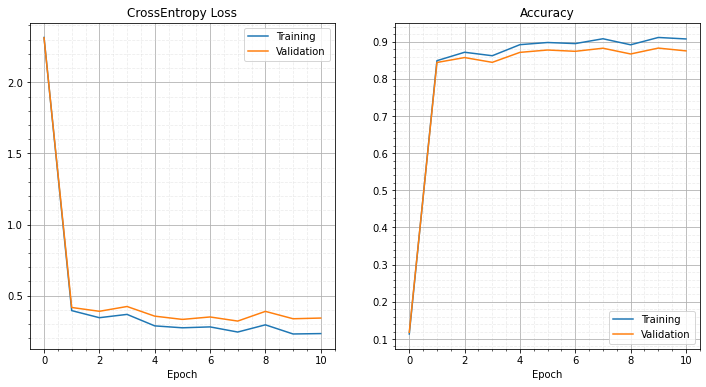

In [ ]:
# SGD
# Résultats pour la meilleure configuration trouvez ci-dessus.
depth = 3   
width = 500    
lr = 0.01           # Some value
# Etant donné le temps de calcul pour un batch petit, on prendra ici batch-size = 20
batch_size = 20   # Some value

torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats

with torch.no_grad():
  data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

  MLP_model = MLPModel(n_features=784, n_hidden_features=width, n_hidden_layers=depth, n_classes=10)
  best_model, best_val_accuracy, logger = train(MLP_model,lr=lr, nb_epochs=10, sgd=True, 
                                                data_loader_train=data_loader_train, data_loader_val=data_loader_val)
  logger.plot_loss_and_accuracy()
  print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

  accuracy_test, loss_test = accuracy_and_loss_whole_dataset(data_loader_test, best_model)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

### Adam: Recherche d'hyperparamètres

Implémentation d'Adam (recherche d'hyperparamètres et analyse du meilleur modèle) et comparer les performances finales avec le meilleur modèle SGD.

In [ ]:
# ADAM
# Résultats pour différents nombre de couche, e.g. 1, 3, 5, et différent nombres de neurone, e.g. 25, 100, 300, 500, 1000.
depth_list = [1,3,5]   
width_list = [25,100,300,500,1000]   
lr = 0.001           # Some value
# Etant donné le temps de calcul pour un batch petit, on prendra ici batch-size = 20
batch_size = 20   # Some value

torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats

with torch.no_grad():
  for depth in depth_list:
    for width in width_list:
      print("------------------------------------------------------------------")
      print("Training model with a depth of {0} layers and a width of {1} units".format(depth, width))
      data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)
      
      MLP_model = MLPModel(n_features=784, n_hidden_features=width, n_hidden_layers=depth, n_classes=10)
      _, val_accuracy, _ = train(MLP_model, lr=lr, nb_epochs=5, sgd=False, data_loader_train=data_loader_train, data_loader_val=data_loader_val)
      print(f"validation accuracy = {val_accuracy*100:.3f}")

------------------------------------------------------------------
Training model with a depth of 1 layers and a width of 25 units
Teta params=[torch.Size([785, 25]), torch.Size([26, 10])]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  0,                   Train:loss=2.528, accuracy=11.2%,                   Valid: loss=2.520, accuracy=11.0%
Epoch  1,                   Train:loss=0.424, accuracy=85.3%,                   Valid: loss=0.445, accuracy=84.7%
Epoch  2,                   Train:loss=0.381, accuracy=86.7%,                   Valid: loss=0.413, accuracy=85.7%
Epoch  3,                   Train:loss=0.388, accuracy=86.3%,                   Valid: loss=0.432, accuracy=84.8%
Epoch  4,                   Train:loss=0.356, accuracy=87.3%,                   Valid: loss=0.409, accuracy=85.7%
Epoch  5,                   Train:loss=0.335, accuracy=88.0%,                   Valid: loss=0.377, accuracy=86.6%
validation accuracy = 86.633
------------------------------------------------------------------
Training model with a depth of 1 layers and a width of 100 units
Teta params=[torch.Size([785, 100]), torch.Size([101, 10])]
Epoch  0,                   Train:loss=2.546, accuracy=11.5%,                   Valid: loss=2.5

#### **Tableau pour la précision sur l'ensemble de validation**
N.B. que les lignes correspondent aux nombre de couche et les colonnes correspondent au nombre de neurone dans chaque couche. 

depth\width  | 25 | 100 | 300 | 500 | 1000 
-------------------|------------------|------------------|------------------|------------------|------------------|
**1**   | 86.633%  | 87.567% | 88.550% | 88.750%| <u>**89.200%**</u>  |
**3** | 86.950%  | 87.633% | 88.217% | 88.150% | 88.583% |
**5**  | 86.233%  | 87.267% | 87.900% | 88.267% | 87.867% |

### Adam: Analyse du meilleur modèle

Teta params=[torch.Size([785, 1000]), torch.Size([1001, 10])]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  0,                   Train:loss=2.286, accuracy=19.1%,                   Valid: loss=2.282, accuracy=19.4%
Epoch  1,                   Train:loss=0.378, accuracy=86.1%,                   Valid: loss=0.402, accuracy=85.9%
Epoch  2,                   Train:loss=0.302, accuracy=89.1%,                   Valid: loss=0.344, accuracy=87.6%
Epoch  3,                   Train:loss=0.335, accuracy=87.8%,                   Valid: loss=0.395, accuracy=86.3%
Epoch  4,                   Train:loss=0.276, accuracy=89.8%,                   Valid: loss=0.346, accuracy=88.1%
Epoch  5,                   Train:loss=0.246, accuracy=91.0%,                   Valid: loss=0.312, accuracy=89.2%
Epoch  6,                   Train:loss=0.247, accuracy=90.6%,                   Valid: loss=0.329, accuracy=88.2%
Epoch  7,                   Train:loss=0.236, accuracy=91.1%,                   Valid: loss=0.326, accuracy=88.7%
Epoch  8,                   Train:loss=0.211, accuracy=92.0%,                   Valid: l

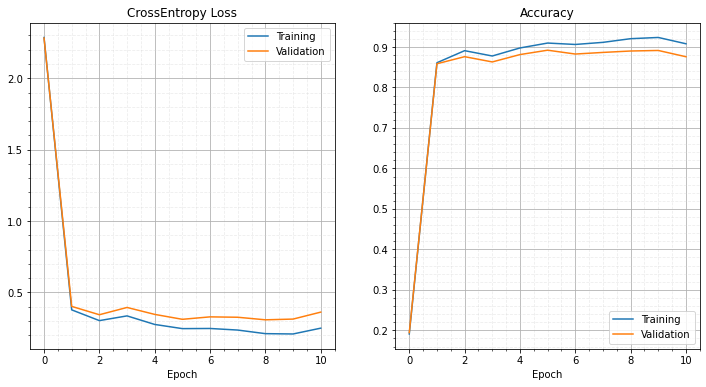

In [ ]:
# ADAM
# Résultats pour la meilleure configuration trouvez ci-dessus.
depth = 1    
width = 1000    .
lr = 0.001           # Some value
batch_size = 20   # Some value

torch.manual_seed(2103232) # Seed pour la reproductibilité des résultats 

with torch.no_grad():
  data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

  MLP_model = MLPModel(n_features=784, n_hidden_features=width, n_hidden_layers=depth, n_classes=10)
  best_model, best_val_accuracy, logger = train(MLP_model,lr=lr, nb_epochs=10, sgd=False, 
                                                data_loader_train=data_loader_train, data_loader_val=data_loader_val)
  logger.plot_loss_and_accuracy()
  print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

  accuracy_test, loss_test = accuracy_and_loss_whole_dataset(data_loader_test, best_model)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

### Analyse des Résultats

Afin de pouvoir reproduire les mêmes résultats à chaque fois, j’ai fixé un seed(2103232).

## SGD 
Etant donné le temps de calcul pour un batch petit et les résultats de la partie 2, on prendra ici batch-size=20 et lr=0.01.
Après l’implémentation du code, j’ai pu obtenir les résultats de précisions suivants en fonction de la profondeur et largeur du réseau de neurones :
 
depth\width  | 25 | 100 | 300 | 500 | 1000 
-------------------|------------------|------------------|------------------|------------------|------------------|
**1**   | 85.750%  | 87.367% | 87.367% | 87.667% | 87.467% |
**3** | 84.933%  | 86.500% | 87.083% | <u>**87.750%**</u> | 87.683% |
**5**  | 83.267%  | 85.650% | 87.083% | 87.250% | 87.683% |



On peut voir qu’on obtient une précision entre 83 et 87% dans tous les cas. On remarque que plus le réseau est large (nombre de neurones par couche), meilleure est la précision. Toutefois, on remarque logiquement le temps de calcul augmente également. 
On peut voir qu’avec 3 couches cachées et 500 neurones par couches, on obtient le meilleur résultat avec une précision de 87.750%.  

En utilisant ce résultat pour tester le meilleur modèle, on obtient les courbes ci-dessus (voir partie SGD).
On remarque que notre modèle apprend bien. En effet, à l’epoch 0, le modèle effectue la première propagation avec les paramètres aléatoires initiaux ce qui explique la perte élevée et la précision de 10%. Puis la modèle apprend en actualisant les paramètres par la minimisation de l’entropie croisée. On remarque bien que l’entropie croisée diminue sous 0.5. La précision est en effet bien meilleure, avec une précision maximale de validation atteinte à l’epoch 9 avec 88.267%.


## ADAM 
Etant donné le temps de calcul pour un batch petit et les résultats de la partie 2, on prendra ici batch-size=20 et lr=0.001.
Cette fois-ci en utilisant ADAM pour l’actualisation, j’ai pu obtenir les résultats de précisions suivants en fonction de la profondeur et largeur du réseau de neurones :


depth\width  | 25 | 100 | 300 | 500 | 1000 
-------------------|------------------|------------------|------------------|------------------|------------------|
**1**   | 86.633%  | 87.567% | 88.550% | 88.750%| <u>**89.200%**</u>  |
**3** | 86.950%  | 87.633% | 88.217% | 88.150% | 88.583% |
**5**  | 86.233%  | 87.267% | 87.900% | 88.267% | 87.867% |


On peut voir qu’on obtient une précision entre 86 et 89% dans tous les cas. On remarque une nouvelle fois que plus le réseau est large (nombre de neurones par couche), meilleure est la précision. 
On peut voir qu’avec 1 couche cachée et 1000 neurones par couches, on obtient le meilleur résultat avec une précision de 89.200%.  

En utilisant ce résultat pour tester le meilleur modèle, on obtient les courbes ci-dessus (voir partie ADAM).
On remarque que notre modèle apprend bien. En effet, à l’epoch 0, le modèle effectue la première propagation avec les paramètres aléatoires initiaux ce qui explique la perte élevée et la précision de 19%. Puis la modèle apprend en actualisant les paramètres par la méthode ADAM. On remarque bien que l’entropie croisée diminue sous 0.5. La précision est en effet bien meilleure, avec une précision maximale de validation atteinte à l’epoch 5 avec 89.2%.
 
Ainsi, avec la méthode Adam, on obtient des résultats (en terme de précision) meilleurs qu’avec la méthode classique SGD. En effet, avec ADAM on gagne 2 à 3% de précision. On peut remarquer également, que peu importe la méthode utilisée ici, dès que l’algorithme commence à apprendre (epoch 1 avec la première actualisation des paramètres), la précision converge tout de suite vers la précision maximale.

## Conclusion
Enfin, si on compare à la première partie, on notera qu’en ajoutant des couches cachées avec des neurones, la précision augmente passant des 80% de précision à ~87% . Finalement, on aura mis en évidence le performance de la régression logistique et des réseaux de neurones pour un problème de classification. 
